#### BJARKE BRODIN - INDBS 2020

# Homework 4

### 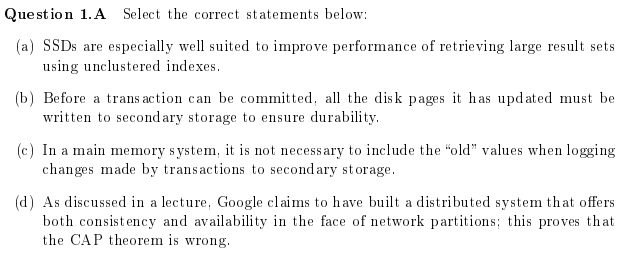

(a) is false because even though random reads are faster on SSDs we still cannot utilize prefetching and pages as well, so unclustered indices are still slow for large sets on SSDs.

(b) is false, we only need to log the changes we have made to ensure durability.

(c) is true, we can simply drop changes by fetching the old values from secondary storage, then write new changes to secondary storage afterwards.

(d) no, google did not break the cap theorem - they merely built around it.

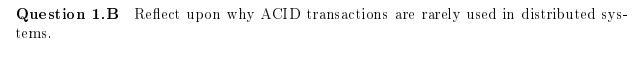

Because true consistency (and isolation for that matter) requires a linearizable execution, this is very hard to implement without losing performance and impossible to implement without losing availability in the case of a partitioned network. Thus we use weaker guarantees in distributed systems, because it is the better tradeoff in most cases (when we don't require strict consistency, which we usually don't).

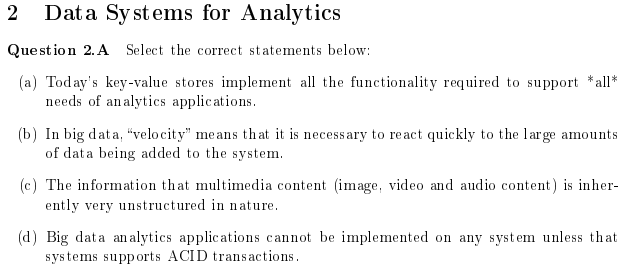

(a) just false

  

(b) yes, it does

  

(c) yes

  

(d) no

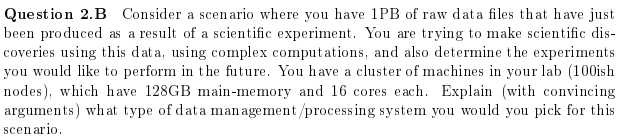

Given that we produce 1PB of data, we either need 10TB of persistent storage for each of our nodes (which is doable i guess, but not optimal), additionally this would leave us unable to operate without overwriting data. This leaves us with some concerns, the pivotal fact becomes the velocity of the 1PB we have produced. In case it is slow we might benefit from any system that is able to extract the key elements of the data, such that we can write the incoming data to cheap storage afterwards (or possibly even forget about it if we are confident that we have extracted what we need) - this could be done using simple mappings or by utilizing machine learning. In case it is velocious data, we also require that whatever pipeline we use is fast enough. To handle the amount of incoming data effectively enough we could attempt to distribute the pipeline accross the entire cluster. 

If we need to do processing that is more complex than what we can extract in a pipeline, we might need to store and organize our data. A possible strategy for this could be to cluster our data using k-means, choosing k as the number of nodes available to us - and then once we have clustered the data, we could start analyzing patterns, by building decision trees or again utilizing machine learning.

The specifics may depend largely on what it is exactly we are trying to find in the data. We may very well be able to just write it all to cheap storage, and then process it a little bit at a time, but this could take a very long time.

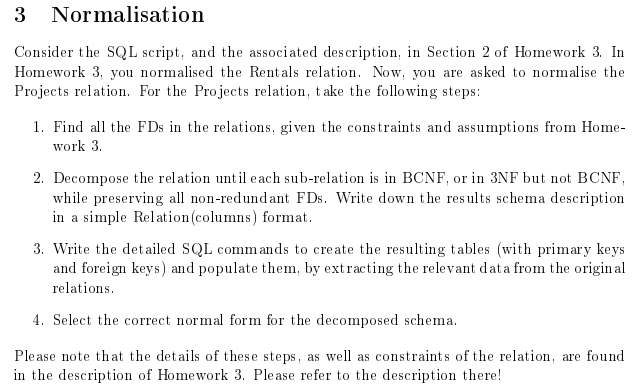

In [ ]:
 -- 1.
 id --> mid
 id --> mn
 pid --> pn
 sid --> sn
 sn --> sid
 mid --> mn
 mn --> mid

2.

Note that <span style="font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre; color: rgb(0, 0, 255);">PRIMARY</span> <span style="font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre; color: rgb(0, 0, 255);">KEY</span> <span style="color: rgb(33, 33, 33); font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre;">(ID,PID,</span> <span style="font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre; color: rgb(0, 0, 255);">SID</span><span style="font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre;">)</span>

M(<u>mid,</u>mn)

S(<u>sid,</u>sn)

I(<u>id</u>,mid)

P(<u>pid</u>,pn)

X(<u>id,pid,sid</u>)

In [ ]:
-- 3

drop table if exists M;
create table M (
    mid int primary key,
    mn varchar(50) NOT NULL
); -- 3NF
insert into M(mid,mn)
select distinct mid,mn from Projects;

drop table if exists S;
create table S(
    sid int primary key,
    sn varchar(50) NOT NULL
); -- 3NF
insert into S(sid, sn)
select distinct sid,sn from Projects;

drop table if exists I;
create table I(
    id int primary key,
    mid int references M(mid) NOT NULL
); -- 4NF
insert into I(id, mid)
select distinct id, mid from Projects;

drop table if exists P;
create table P(
    pid int primary key,
    pn varchar(50) NOT NULL
); -- 4NF
insert into P(pid, pn)
select distinct pid, pn from Projects;

drop table if exists X;
create table X(
    id int references I(id),
    pid int references P(pid),
    sid int references S(sid),
    primary key (id,pid,sid)
); -- 4NF

4.

Since M and S are in 3NF, the decomposition cannot be described as normal beyond 3NF. So it is in 3NF to be clear.

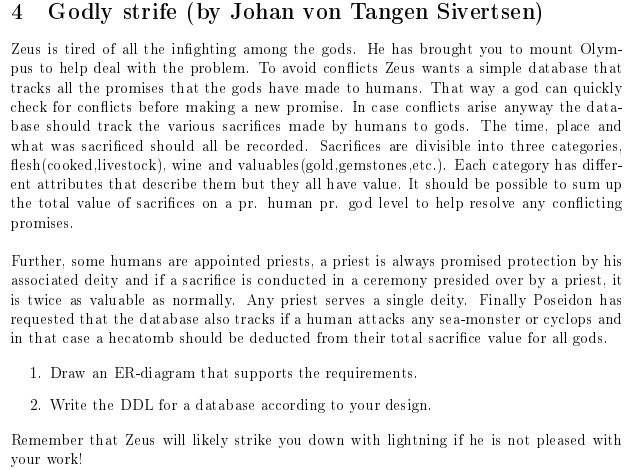

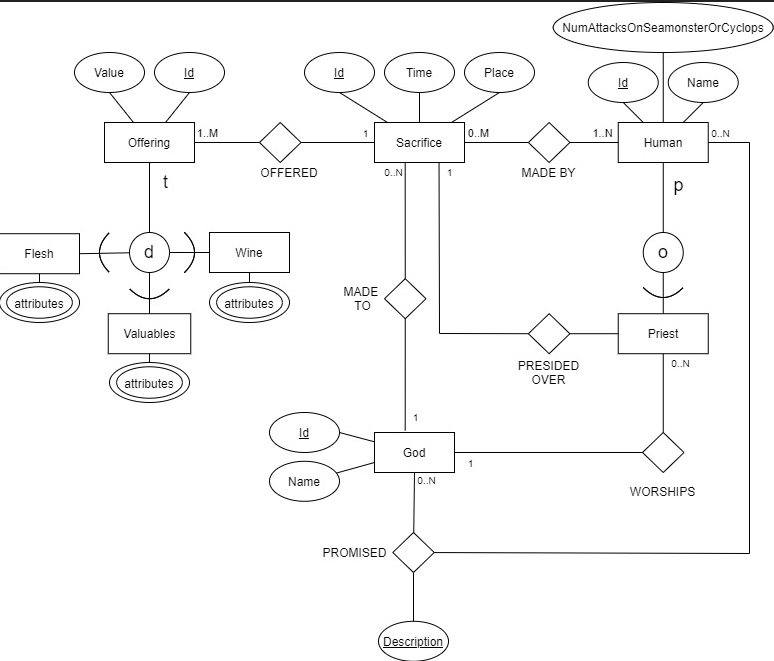

In [ ]:
drop schema if exists Olympus cascade;
create schema Olympus;

-- Domains

create domain Olympus.natural as int
check (value >= 0);


-- Tables

create table Olympus.Human (
    id serial primary key,
    name varchar(50) not null,
    aquarialAggresions Olympus.natural not null
);

create table Olympus.Priest (
    id int references Olympus.Human(id) primary key
);

create table Olympus.God (
    id serial primary key,
    name varchar(50) not null
);

create table Olympus.Offering (
    id serial primary key,
    value Olympus.natural not null
);

create table Olympus.Wine (
    id int references Olympus.Offering(id) primary key
);

create table Olympus.Valuable (
    id int references Olympus.Offering(id) primary key
);

create table Olympus.Flesh (
    id int references Olympus.Offering(id) primary key
);

create table Olympus.PriestGod (
    priestid int references Olympus.Priest(id) primary key,
    godid int references Olympus.God(id) not null
);

create table Olympus.Sacrifice (
    id serial primary key,
    time timestamp not null,
    place varchar(50) not null
);

create table Olympus.SacrificeHuman (
    sacid int references Olympus.Sacrifice(id),
    humid int references Olympus.Human(id),
    primary key(sacid,humid)
);

create table Olympus.SacrificeOffer (
    sacid int references Olympus.Sacrifice(id),
    offid int references Olympus.Offering(id),
    primary key(sacid,offid)
);

create table Olympus.SacrificeGod (
    sacid int references Olympus.Sacrifice(id),
    godid int references Olympus.God(id),
    primary key(sacid, godid)
);

create table Olympus.SacrificePriest (
    sacid int references Olympus.Sacrifice(id),
    priestid int references Olympus.Priest(id),
    primary key(sacid, priestid)
);

create table Olympus.Promise (
    godid int references Olympus.God(id),
    humid int references Olympus.Human(id),
    description text not null,
    primary key (godid, humid, description)
);

-- Everything below is pretty much just extra i think

-- Views
create view Olympus.SpecialSacrifices as
select S.id, S.time, S.place, V.val*2 as value
from Olympus.SacrificePriest SP
join Olympus.Sacrifice S on SP.sacid = S.id
join (
    select SO.sacid as id, sum(O.value) as val
    from Olympus.SacrificeOffer SO
    join Olympus.Offering O on SO.offid = O.id
    group by SO.sacid
) V on S.id = V.id;


-- Triggers & checks

create or replace function Olympus.insertDisjoint()
returns trigger
as $$ begin
    if exists (select * from Olympus.Offering where id = new.id) then
        raise unique_violation 
        using message = 'Duplicate offering ID: ' || new.id;
    else 
        insert into Olympus.Wine(id,value)
        values(new.id, new.value);
        return new;
    end if;
end; $$ language plpgsql;

create trigger insertWine 
before insert 
on Olympus.Wine
for each row
execute procedure Olympus.insertDisjoint();

create trigger insertFlesh 
before insert 
on Olympus.Flesh
for each row
execute procedure Olympus.insertDisjoint();

create trigger insertValuable 
before insert 
on Olympus.Valuable
for each row
execute procedure Olympus.insertDisjoint();

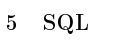  

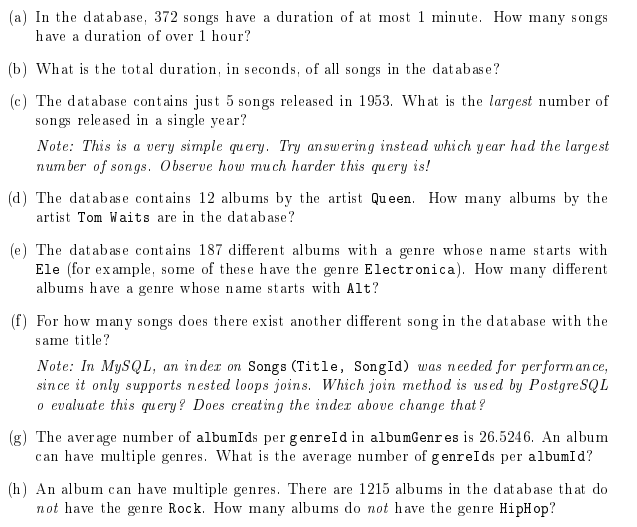

In [42]:
-- a
select count(*) 
from songs
where duration >= time '01:00:00';

(1 row(s) affected)

Total execution time: 00:00:00.005

count
2


In [43]:
-- b
select 
    sum(extract(hours from duration)) * 60 * 60 + 
    sum(extract(minutes from duration)) * 60 +
    sum(extract(seconds from duration)) as total
from songs;

(1 row(s) affected)

Total execution time: 00:00:00.009

total
3883371.0


In [17]:
-- c
select max(c) 
from (
    select count(*) as c
    from songs
    group by extract(year from releasedate)
) by_year;

(1 row(s) affected)

Total execution time: 00:00:00.009

max
833


In [22]:
-- d
select count(AA.albumid)
from artists A
join albumartists AA
on A.artist like 'Tom Waits'
and AA.artistid = A.artistid;

(1 row(s) affected)

Total execution time: 00:00:00.005

count
24


In [23]:
-- e
select count(distinct AG.albumid)
from genres G 
join albumgenres AG 
on G.genre like 'Alt%'
and G.genreid = AG.genreid;

(1 row(s) affected)

Total execution time: 00:00:00.004

count
421


In [29]:
-- f
select count(distinct S1.songid)
from songs S1 
join songs S2
on S1.songid != S2.songid 
and S1.title = S2.title;

(1 row(s) affected)

Total execution time: 00:00:00.026

count
2072


In [37]:
-- g
select AVG(c) 
from (
    select count(distinct genreid) as c
    from albumgenres
    group by albumid
) AGID;

(1 row(s) affected)

Total execution time: 00:00:00.005

avg
1.1994069681245367


In [26]:
-- h
select count(*) from (
select A.albumid
from albumgenres A
group by albumid
having not exists (
    select *
    from albumgenres B
    where A.albumid = B.albumid 
    and B.genreid = (select genreid from genres where genre like 'HipHop')
)
union 
(
    select AL.albumid
    from albums AL
    where not exists (
        select *
        from albumgenres AG
        where AG.albumid = AL.albumid
    )
)) X;

(1 row(s) affected)

Total execution time: 00:00:00.006

count
1278
